Episode: 0 24.0  Epsilon: 1.00  Mean Rewards 24.0
Episode: 100 17.0  Epsilon: 1.00  Mean Rewards 22.0
Episode: 200 28.0  Epsilon: 1.00  Mean Rewards 21.0
Episode: 300 29.0  Epsilon: 1.00  Mean Rewards 22.4
Episode: 400 44.0  Epsilon: 1.00  Mean Rewards 22.5
Episode: 500 14.0  Epsilon: 1.00  Mean Rewards 24.3
Episode: 600 15.0  Epsilon: 0.99  Mean Rewards 22.3
Episode: 700 25.0  Epsilon: 0.99  Mean Rewards 25.0
Episode: 800 29.0  Epsilon: 0.99  Mean Rewards 22.3
Episode: 900 16.0  Epsilon: 0.99  Mean Rewards 20.9
Episode: 1000 14.0  Epsilon: 0.99  Mean Rewards 22.9
Episode: 1100 17.0  Epsilon: 0.99  Mean Rewards 23.2
Episode: 1200 10.0  Epsilon: 0.99  Mean Rewards 21.8
Episode: 1300 10.0  Epsilon: 0.99  Mean Rewards 23.1
Episode: 1400 16.0  Epsilon: 0.99  Mean Rewards 19.4
Episode: 1500 19.0  Epsilon: 0.99  Mean Rewards 21.2
Episode: 1600 18.0  Epsilon: 0.98  Mean Rewards 22.0
Episode: 1700 24.0  Epsilon: 0.98  Mean Rewards 22.4
Episode: 1800 20.0  Epsilon: 0.98  Mean Rewards 23.1
Episo

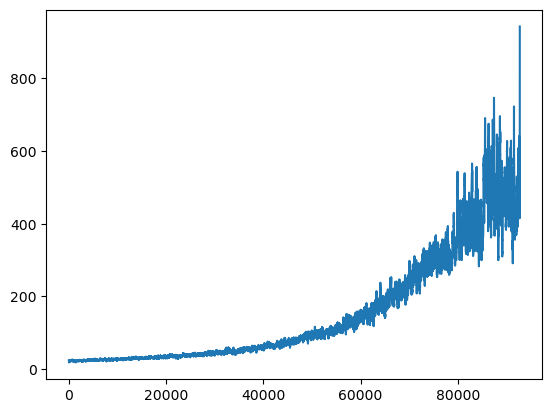

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(is_training=True, render=False):

    env = gym.make('CartPole-v1', render_mode='human' if render else None)

    # Divide position, velocity, pole angle, and pole angular velocity into segments
    pos_space = np.linspace(-2.4, 2.4, 10)
    vel_space = np.linspace(-4, 4, 10)
    ang_space = np.linspace(-.2095, .2095, 10)
    ang_vel_space = np.linspace(-4, 4, 10)

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(ang_vel_space)+1, env.action_space.n)) # init a 11x11x11x11x2 array
    else:
        f = open('cartpole.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.1 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.00001 # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = []

    i = 0

    # for i in range(episodes):
    while(True):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards < 10000):

            if is_training and rng.random() < epsilon:
                # Choose random action  (0=go left, 1=go right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av= np.digitize(new_state[3], ang_vel_space)

            if is_training:
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - q[state_p, state_v, state_a, state_av, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av= new_state_av

            rewards+=reward

            if not is_training and rewards%100==0:
                print(f'Episode: {i}  Rewards: {rewards}')

        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])

        if is_training and i%100==0:
            print(f'Episode: {i} {rewards}  Epsilon: {epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')

        if mean_rewards>1000:
            break

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        i+=1

    env.close()

    # Save Q table to file
    if is_training:
        f = open('cartpole.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = []
    for t in range(i):
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
    plt.plot(mean_rewards)
    plt.savefig(f'cartpole.png')

if __name__ == '__main__':
    run(is_training=True, render=False)

    # run(is_training=False, render=True)

In [ ]:
def policy(matrix, weight):
    """Computes a policy using the given weight matrix.
    Args:
        matrix: a state matrix
        weight: a weight matrix
    Returns:
        the policy"""

    exponentiated_matrix = np.exp(matrix.dot(weight))
    policy_values = exponentiated_matrix / np.sum(exponentiated_matrix, axis=1, keepdims=True)

    return policy_values

def policy_gradient(state, weight):
    """Computes the Monte-Carlo policy gradient based on a
    state and a weight matrix.
    Args:
        state: matrix representing the current observation of the environment
        weight: matrix of random weight
    Returns:
        the action and the gradient (in this order)"""

    # get action prob. dist. from policy
    actions = policy(state, weight)
    # get action based on prob. dist.
    action = np.random.choice(len(actions[0]), p=actions[0])
    # reshaping to fit softmax
    s = actions.reshape(-1, 1)
    # apply softmax function to s and access value at action
    softmax = (np.diagflat(s) - np.dot(s, s.T))[action, :]
    # calculate the derivative of log as softmax / policy at action
    dlog = softmax / actions[0, action]
    # find gradient from input state matrix using dlog
    gradient = state.T.dot(dlog[None, :])
    # return action and the policy gradient
    return action, gradient


def train(env, nb_episodes, alpha=0.000045, gamma=0.98):
    """Does full training of the agent using the policy gradient method.
    Args:
        env: The environment to train the agent on.
        nb_episodes: The number of episodes to train the agent for.
        alpha: The learning rate.
        gamma: The discount factor.
    Return:
        All values of the score (sum of all rewards during one episode loop)"""

